- [ETL](#ETL)
- [Переобученная модель дерева решений](#Переобученная-модель-дерева-решений)
- [Обобщающая модель дерева решений](#Обобщающая-модель-дерева-решений)

In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.fixes import loguniform

from utils import decision_tree as dt
from utils import definitions as defs

## ETL

In [2]:
df = pd.read_excel(defs.ETLED_DATA_PATH_step_2)

Y = df[defs.LABEL]
X = df.drop(defs.LABEL, axis=1)

In [3]:
categorical_feature_names = [
    defs.QUESTION_3,
    defs.QUESTION_6,
    defs.QUESTION_8,
    defs.QUESTION_10,
    defs.QUESTION_15,
    defs.QUESTION_23,
    defs.QUESTION_25,
    defs.QUESTION_30,
    defs.QUESTION_33,
    defs.QUESTION_34,
    defs.QUESTION_35,
]

rank_feature_names = {
    defs.QUESTION_5: defs.ANSWERS_5,
    defs.QUESTION_7: defs.ANSWERS_7,
    defs.QUESTION_9: defs.ANSWERS_9,
    defs.QUESTION_11: defs.ANSWERS_11,
    defs.QUESTION_12: defs.ANSWERS_12,
    defs.QUESTION_13: defs.ANSWERS_13,
    defs.QUESTION_14: defs.ANSWERS_14,
    defs.QUESTION_16: defs.ANSWERS_16_17_18,
    defs.QUESTION_17: defs.ANSWERS_16_17_18,
    defs.QUESTION_18: defs.ANSWERS_16_17_18,
    defs.QUESTION_19: defs.ANSWERS_19_20,
    defs.QUESTION_20: defs.ANSWERS_19_20,
    defs.QUESTION_26: defs.ANSWERS_26,
    defs.QUESTION_27: defs.ANSWERS_27,
    defs.QUESTION_28: defs.ANSWERS_28,
    defs.QUESTION_29: defs.ANSWERS_29,
    defs.QUESTION_31: defs.ANSWERS_31,
    defs.QUESTION_32: defs.ANSWERS_32,
}

numerical_feature_names = [
    defs.QUESTION_2,
    defs.QUESTION_4,
    defs.QUESTION_22,
    defs.QUESTION_24,
]

## Переобученная модель дерева решений

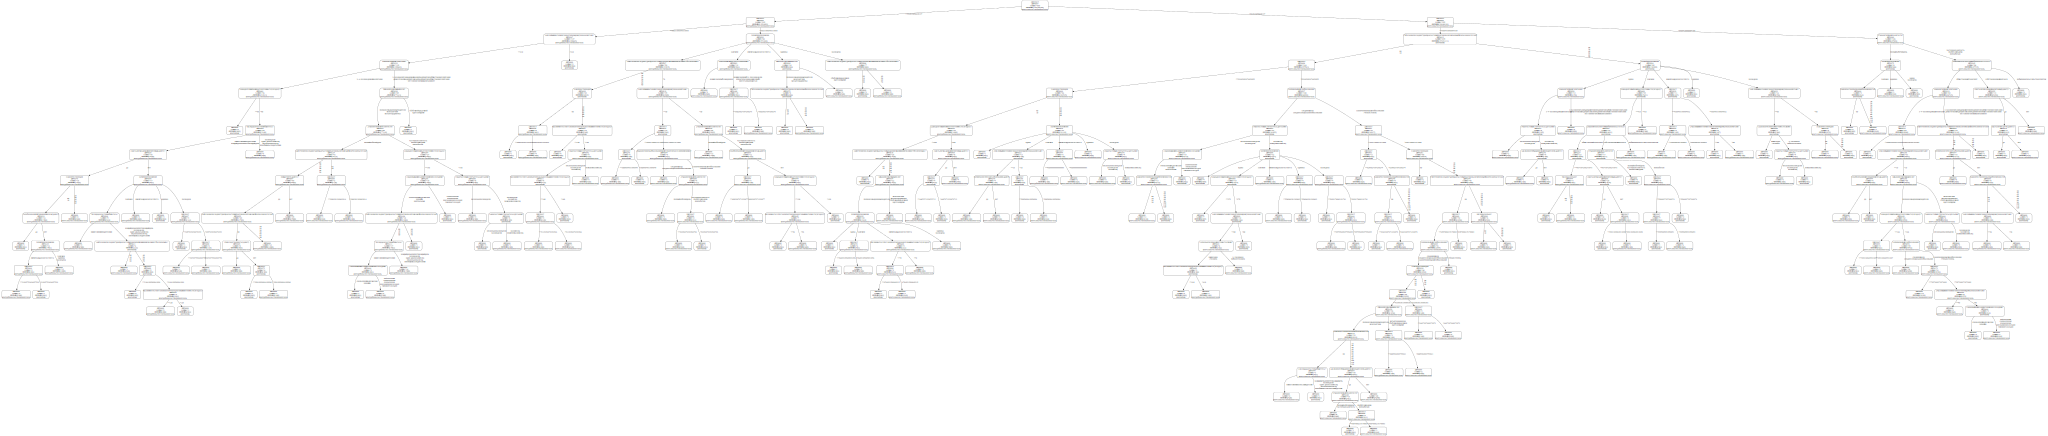

In [4]:
overfitted_tree = dt.DecisionTree()
overfitted_tree.fit(
    X, Y,
    categorical_feature_names=categorical_feature_names,
    rank_feature_names=rank_feature_names,
    numerical_feature_names=numerical_feature_names,
)
overfitted_tree.render(
    rounded=True,
    show_impurity=True,
    show_num_samples=True,
    show_distribution=True,
    show_label=True,
    filename='my overfitted tree.gv',
    format='png',
)

In [5]:
display.Image('my overfitted tree.gv.png')

In [6]:
# Картинки встроены в jupyter notebook. Теперь удаляем файлы, чтобы они не засоряли проект.
os.remove('my overfitted tree.gv')
os.remove('my overfitted tree.gv.png')

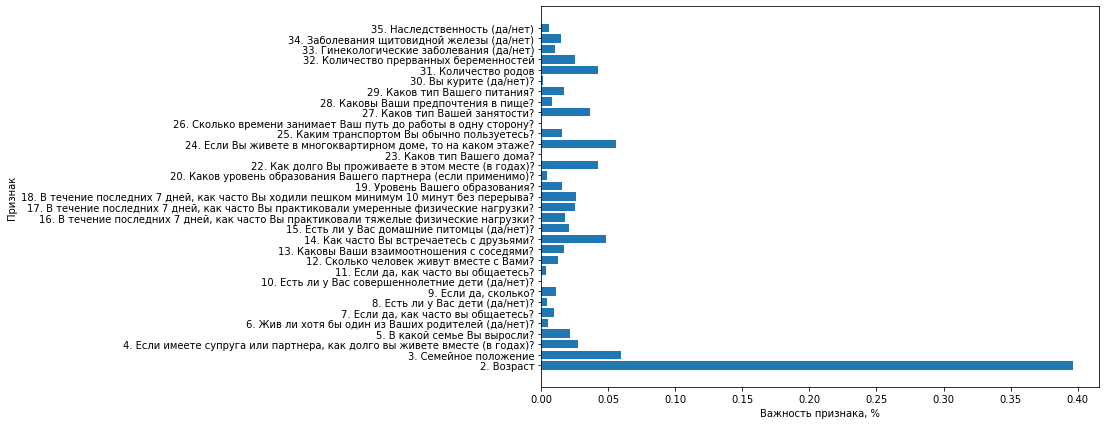

In [7]:
features = list(overfitted_tree.feature_importances.keys())
importances = overfitted_tree.feature_importances.values()

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(features, importances, align='center')
ax.set_xlabel('Важность признака, %')
ax.set_ylabel('Признак')

plt.show()

## Обобщающая модель дерева решений

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    train_size=0.7,
    stratify=Y,
)

Кросс-валидации гиперпараметров.

In [9]:
param_grid = [
    {
        'min_samples_split': [2],
        'min_samples_leaf': [1],
    },
    {
        'min_samples_split': [4],
        'min_samples_leaf': [1, 2],
    },
    {
        'min_samples_split': [8],
        'min_samples_leaf': [1, 2, 4],
    },
    {
        'min_samples_split': [16],
        'min_samples_leaf': [1, 2, 4, 8],
    },
    {
        'min_samples_split': [32],
        'min_samples_leaf': [1, 2, 4, 8, 16],
    },
    {
        'min_samples_split': [64],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
    },
    {
        'min_samples_split': [128],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64],
    },
    {
        'min_samples_split': [256],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128],
    },
    {
        'min_samples_split': [512],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128, 256],
    },
]

fit_params = {
    'categorical_feature_names': categorical_feature_names,
    'rank_feature_names': rank_feature_names,
    'numerical_feature_names': numerical_feature_names,
}

search = GridSearchCV(
    dt.DecisionTree(),
    param_grid,
    cv=StratifiedShuffleSplit(n_splits=5),
)
search.fit(X_train, Y_train, **fit_params)

print('Лучшие гиперпараметры:')
for param, value in search.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры:
min_samples_leaf: 1
min_samples_split: 2


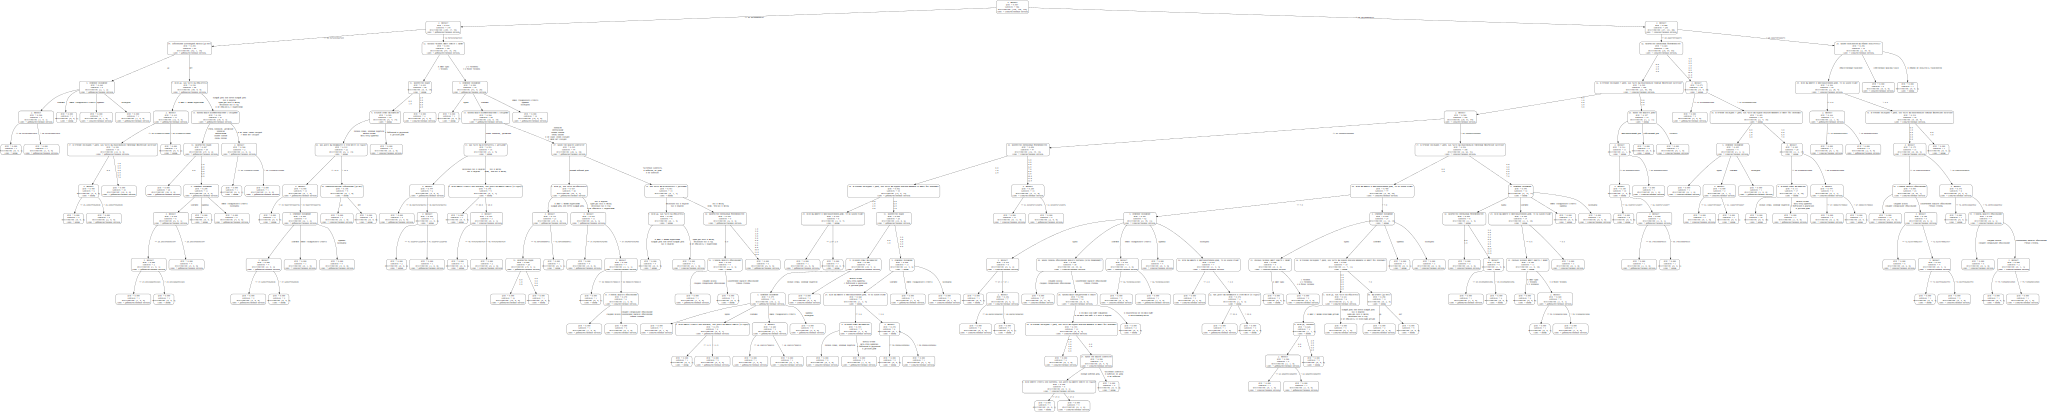

In [10]:
generalizing_tree = dt.DecisionTree(**search.best_params_)
generalizing_tree.fit(
    X_train, Y_train,
    categorical_feature_names=categorical_feature_names,
    rank_feature_names=rank_feature_names,
    numerical_feature_names=numerical_feature_names,
)
generalizing_tree.render(
    rounded=True,
    show_impurity=True,
    show_num_samples=True,
    show_distribution=True,
    show_label=True,
    filename='my generalizing tree.gv',
    format='png',
)

In [11]:
display.Image('my generalizing tree.gv.png')

In [12]:
# Картинки встроены в jupyter notebook. Теперь удаляем файлы, чтобы они не засоряли проект.
os.remove('my generalizing tree.gv')
os.remove('my generalizing tree.gv.png')

In [13]:
generalizing_tree.score(X_test, Y_test)

0.6206896551724138